# Deep Colorization

## Overview

This notebook creates a model that is able to colorize images to a certain extent, which combines a Fast deep Convolutional Neural Network trained from scratch with high-level features extracted from the MobileNet pre-trained model. This encoder-decoder model can process images of any size and aspect ratio. The training of this model is done on 60K images of MS-COCO dataset. How this model performs in coloring images are also showing in result section.

This notebook's work is inspired from https://github.com/titu1994/keras-mobile-colorizer which is also transfer to ipynb notebook too [[link]()].

## Introduction

There is something uniquely and powerfully satisfying about the simple act of adding color to black and white imagery. Moreover this coloring of gray-scale images can have a big impact in a wide variety of domains, for instance, re-master of historical images, dormant memories or expressing artistic creativity and improvement of surveillance feeds.

The information content of a gray-scale image is rather limited, thus adding the color components can provide more insights about its semantics. In the context of deep learning, models such as Inception [[ref]()], VGG [[ref]()] and others are usually trained using colored image datasets. When applying these networks on grayscale images, a prior colorization step can help improve the results. However, designing and implementing an effective and reliable system that automates this process still remains nowadays as a challenging task.

In this regard, below is the proposed model that is able to colorize images to a certain extent, combining a DCNN [[ref]()] architecture which utilizes a U-Net inspired model conditioned on MobileNet class features to generate a mapping from Grayscale to Color image. This work is based on the https://github.com/titu1994/keras-mobile-colorizer and https://github.com/baldassarreFe/deep-koalarization [[research paper](https://arxiv.org/pdf/1712.03400.pdf)].

### My contribution are as follows: 
  
1. Using fast algorithms for CNNs based on the minimal filtering algorithms pioneered by Winograd [[research paper](https://arxiv.org/abs/1509.09308)]
2. Analysis and intuition behind a colorization architecture based on CNNs.

## Background
Below are the few components that are used in the architecture of this model. Basic introduction of these components are given and more information you see the links provided in each section.


### U-Net: Convolutional Networks

The U-Net architecture is illustrated in below shown figure. It consists of a contracting path (left side) and an expansive path (right side). The architecture is that in the upsampling part, it has a large number of feature channels, which allow the network to propagate context information to higher resolution layers. As a consequence,
the expansive path is more or less symmetric to the contracting path, and yields a u-shaped architecture.

The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two convolutions mostly 3x3 (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a max pooling mostly 2x2 operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels. Every step in the expansive path consists of an upsampling of the feature map followed by a convolution mostly 2x2 (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two convolutions mostly 2x2 , each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution. At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. In total the below network has 23 convolutional layers.


![U-Net Architecture](https://raw.githubusercontent.com/krypten/MobileDeepColorization/master/docs/images/u_net_architecture.png)



### MobileNet  
  
MobileNets are an efficent class of convolutional neural network. The main difference between the MobileNet architecture and a “traditional” CNN’s is instead of a single 3x3 convolution layer followed by batch norm and ReLU, MobileNets split the convolution into a 3x3 depthwise convolution and a 1×1 convolution called a pointwise convolution.


MobileNets introduce two simple global hyperparameters that efficiently trade off between latency and
accuracy : width multiplier and resolution multiplier. These hyper-parameters allow the model builder to choose the right sized model for their application based on the constraints of the problem. The width multiplier allows us to thin the network, while the resolution multiplier changes the input dimensions of the image, reducing the internal representation at every layer.

To learn more about how MobileNets work, read the [research paper](https://arxiv.org/pdf/1704.04861.pdf).

![MobileNet convolution](https://raw.githubusercontent.com/krypten/MobileDeepColorization/master/docs/images/mobilenet_architecture.png)

## Architecture
...


![Deep Colorization Architecture](https://raw.githubusercontent.com/krypten/MobileDeepColorization/master/docs/images/deep_colorization_architecture.png)

## Experimentation

##### Install required modules

In [0]:
%%capture --no-display

# Install pip packages in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install hazm
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install pydot
!{sys.executable} -m pip install requests
!{sys.executable} -m pip install scikit-image
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install wget

##### Import required modules and configurations

In [2]:
## Import required modules
import glob

import keras

from keras.layers import Conv2D, Input, Reshape, RepeatVector, concatenate, UpSampling2D, Flatten, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.losses import mean_squared_error
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import tensorflow as tf


# Fetch the util file and import it
if os.path.exists('utils.py'):
  os.remove('utils.py')
  print('Removed the old copy of utils.py')
!wget https://raw.githubusercontent.com/krypten/MobileDeepColorization/master/utils.py

import utils
from utils import TensorBoardBatch

# Configure tf to allocate memory as-needed
utils.configure_tensorflow()

sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


--2018-06-14 07:10:15--  https://raw.githubusercontent.com/krypten/MobileDeepColorization/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16659 (16K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  16.27K  --.-KB/s    in 0.01s   

2018-06-14 07:10:15 (1.29 MB/s) - ‘utils.py’ saved [16659/16659]

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


In [0]:
# Constants
TRAINING_TF_FILE_ID = "1DtW-secVk2-QdL1vUGgEPc3iL8T9CEnF"
TRAINING_DATASET_URL = "http://images.cocodataset.org/zips/train2014.zip"
TRAINING_TFRECORDS_PATH = "data/images.tfrecord"  # local path to tf record directory

VALIDATION_TF_FILE_ID = "1Gf6qtUGkk_yYiMffn1a1_8GzxJcQjv6k"
VALIDATION_DATASET_URL = "http://images.cocodataset.org/zips/val2014.zip"
VALIDATION_TFRECORDS_PATH = "data/val_images.tfrecord"  # local path to tf record directory

TEST_DATASET_URL = "http://images.cocodataset.org/zips/test2014.zip"

WEIGHTS_FILE_NAME = 'weights/mobilenet_model_improved.h5' # 'weights/mobilenet_model_original.h5'

IMAGE_SIZE = 128  # Global constant image size
EMBEDDING_IMAGE_SIZE = 224  # Global constant embedding size

### Model
...

### Hyperparameters

In [0]:
### Hyperparameters
batch_size = 100
epochs = 10
image_size = 128
nb_train_images = 60000 # there are 82783 images in MS-COCO, set this to how many samples you want to train on.

##### Get the Data
Run the following cell to download either the preprocessed dataset or dataset which is then converted to TFRecords.

In [5]:
# Save the train tf record file
utils.save_data_tfrecord(TRAINING_TFRECORDS_PATH, TRAINING_DATASET_URL, TRAINING_TF_FILE_ID)
print("{} has size {} MB".format(TRAINING_TFRECORDS_PATH, os.stat(TRAINING_TFRECORDS_PATH).st_size / 1024 / 1024))

# Save the validation tf record file
utils.save_data_tfrecord(VALIDATION_TFRECORDS_PATH, VALIDATION_DATASET_URL, VALIDATION_TF_FILE_ID)
print("{} has size {} MB".format(VALIDATION_TFRECORDS_PATH, os.stat(VALIDATION_TFRECORDS_PATH).st_size / 1024 / 1024))

data/images.tfrecord has size 14381.601808547974 MB
data/val_images.tfrecord has size 7040.7601499557495 MB


### Metrics and Loss function


In [0]:
mse_weight = 1.0 #1e-3

# set these to zeros to prevent learning
perceptual_weight = 1. / (2. * 128. * 128.) # scaling factor
attention_weight = 1.0 # 1.0


# shows the minimum value of the AB channels
def y_true_min(yt, yp):
    return K.min(yt)


# shows the maximum value of the RGB AB channels
def y_true_max(yt, yp):
    return K.max(yt)


# shows the minimum value of the predicted AB channels
def y_pred_min(yt, yp):
    return K.min(yp)


# shows the maximum value of the predicted AB channels
def y_pred_max(yt, yp):
    return K.max(yp)


def gram_matrix(x):
    assert K.ndim(x) == 4

    with K.name_scope('gram_matrix'):
        if K.image_data_format() == "channels_first":
            batch, channels, width, height = K.int_shape(x)
            features = K.batch_flatten(x)
        else:
            batch, width, height, channels = K.int_shape(x)
            features = K.batch_flatten(K.permute_dimensions(x, (0, 3, 1, 2)))

        gram = K.dot(features, K.transpose(features)) # / (channels * width * height)
    return gram


def l2_norm(x):
    return K.sqrt(K.sum(K.square(x)))


def attention_vector(x):
    if K.image_data_format() == "channels_first":
        batch, channels, width, height = K.int_shape(x)
        filters = K.batch_flatten(K.permute_dimensions(x, (1, 0, 2, 3)))  # (channels, batch*width*height)
    else:
        batch, width, height, channels = K.int_shape(x)
        filters = K.batch_flatten(K.permute_dimensions(x, (3, 0, 1, 2)))  # (channels, batch*width*height)

    filters = K.mean(K.square(filters), axis=0)  # (batch*width*height,)
    filters = filters / l2_norm(filters)  # (batch*width*height,)
    return filters


def total_loss(y_true, y_pred):
    mse_loss = mse_weight * mean_squared_error(y_true, y_pred)
    perceptual_loss = perceptual_weight * K.sum(K.square(gram_matrix(y_true) - gram_matrix(y_pred)))
    attention_loss = attention_weight * l2_norm(attention_vector(y_true) - attention_vector(y_pred))

    return mse_loss + perceptual_loss + attention_loss

### Build Model


In [0]:
def build_mobilenet_model(img_size, lr=1e-3):
    '''
    Creates a Colorizer model. Note the difference from the report
    - https://github.com/baldassarreFe/deep-koalarization/blob/master/report.pdf
    I use a long skip connection network to speed up convergence and
    boost the output quality.
    '''
    ## Encoder Model
    encoder_input = Input(shape=(img_size, img_size, 1,))
    encoder1 = Conv2D(64, (3, 3), padding='same', activation='relu', strides=(2, 2))(encoder_input)
    encoder = Conv2D(128, (3, 3), padding='same', activation='relu')(encoder1)
    encoder2 = Conv2D(128, (3, 3), padding='same', activation='relu', strides=(2, 2))(encoder)
    encoder = Conv2D(256, (3, 3), padding='same', activation='relu')(encoder2)
    encoder = Conv2D(256, (3, 3), padding='same', activation='relu', strides=(2, 2))(encoder)
    encoder = Conv2D(512, (3, 3), padding='same', activation='relu')(encoder)
    encoder = Conv2D(512, (3, 3), padding='same', activation='relu')(encoder)
    encoder = Conv2D(256, (3, 3), padding='same', activation='relu')(encoder)

    ## Input Fusion
    # Decide the image shape at runtime to allow prediction on
    # any size image, even if training is on 128x128
    batch, height, width, channels = K.int_shape(encoder)

    mobilenet_features_ip = Input(shape=(1000,))
    fusion = RepeatVector(height * width)(mobilenet_features_ip)
    fusion = Reshape((height, width, 1000))(fusion)
    fusion = concatenate([encoder, fusion], axis=-1)
    fusion = Conv2D(256, (1, 1), padding='same', activation='relu')(encoder)

    ## Decoder Model
    decoder = Conv2D(128, (3, 3), padding='same', activation='relu')(fusion)
    decoder = UpSampling2D()(decoder)
    #decoder = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu')(decoder)
    decoder = concatenate([decoder, encoder2], axis=-1)
    decoder = Conv2D(64, (3, 3), padding='same', activation='relu')(decoder)
    decoder = Conv2D(64, (3, 3), padding='same', activation='relu')(decoder)
    decoder = UpSampling2D()(decoder)
    #decoder = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='relu')(decoder)
    decoder = concatenate([decoder, encoder1], axis=-1)
    decoder = Conv2D(32, (3, 3), padding='same', activation='relu')(decoder)
    decoder = Conv2DTranspose(2, (4, 4), strides=(2, 2), padding='same', activation='tanh')(decoder)
    # decoder = Conv2D(2, (3, 3), padding='same', activation='tanh')(decoder)
    # decoder = UpSampling2D((2, 2))(decoder)

    model = Model([encoder_input, mobilenet_features_ip], decoder, name='Colorizer')
    model.compile(optimizer=Adam(lr), loss=total_loss, metrics=[y_true_max,
                                                                y_true_min,
                                                                y_pred_max,
                                                                y_pred_min])

    print("Model built and compiled")
    return model

In [8]:
# Model Summary
model = build_mobilenet_model(IMAGE_SIZE, 1e-3)
model.summary()

Model built and compiled
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 128)  73856       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 128)  147584      conv2d_2[0][0]                   
____________________________________________________________________________________

## Training
...

In [9]:
# Continue training if weights are available
if not os.path.exists('weights/'):
    os.makedirs('weights/')

#if os.path.exists(WEIGHTS_FILE_NAME):
#    model.load_weights(WEIGHTS_FILE_NAME)

# Use Batchwise TensorBoard callback
tensor_board = TensorBoardBatch(batch_size=batch_size)
checkpoint = ModelCheckpoint(WEIGHTS_FILE_NAME, monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)
callbacks_list = [checkpoint, tensor_board]

# Training model
model.fit_generator(generator=utils.train_generator(TRAINING_TFRECORDS_PATH, batch_size, IMAGE_SIZE),
                    steps_per_epoch=nb_train_images // batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks_list,
                    validation_data=utils.val_batch_generator(VALIDATION_TFRECORDS_PATH, batch_size, IMAGE_SIZE),
                    validation_steps=1
                   )

Epoch 1/10
595/600 [============================>.] - ETA: 3s - loss: 11403.6910 - y_true_max: 0.7168 - y_true_min: -0.7001 - y_pred_max: 0.5812 - y_pred_min: -0.5951

600/600 [==============================] - 363s 605ms/step - loss: 11387.8578 - y_true_max: 0.7168 - y_true_min: -0.7003 - y_pred_max: 0.5843 - y_pred_min: -0.5979 - val_loss: 5884.4175 - val_y_true_max: 0.6800 - val_y_true_min: -0.6952 - val_y_pred_max: 0.9330 - val_y_pred_min: -0.9113

Epoch 00001: loss improved from inf to 11387.85779, saving model to weights/mobilenet_model_improved.h5
Epoch 2/10
174/600 [=======>......................] - ETA: 4:09 - loss: 10981.1676 - y_true_max: 0.7160 - y_true_min: -0.6964 - y_pred_max: 0.9530 - y_pred_min: -0.9388

600/600 [==============================] - 352s 587ms/step - loss: 10792.8364 - y_true_max: 0.7175 - y_true_min: -0.6968 - y_pred_max: 0.9653 - y_pred_min: -0.9573 - val_loss: 7867.3643 - val_y_true_max: 0.7148 - val_y_true_min: -0.6940 - val_y_pred_max: 0.9839 - val_y_pred_min: -0.9864

Epoch 00002: loss improved from 11387.85779 to 10792.83643, saving model to weights/mobilenet_model_improved.h5
Epoch 3/10
 57/600 [=>............................] - ETA: 5:16 - loss: 10009.8870 - y_true_max: 0.7147 - y_true_min: -0.6948 - y_pred_max: 0.9842 - y_pred_min: -0.9836

600/600 [==============================] - 351s 586ms/step - loss: 10455.2203 - y_true_max: 0.7175 - y_true_min: -0.6975 - y_pred_max: 0.9846 - y_pred_min: -0.9858 - val_loss: 5834.9531 - val_y_true_max: 0.7242 - val_y_true_min: -0.7195 - val_y_pred_max: 0.9959 - val_y_pred_min: -0.9964

Epoch 00003: loss improved from 10792.83643 to 10455.22034, saving model to weights/mobilenet_model_improved.h5
Epoch 4/10
 24/600 [>.............................] - ETA: 5:36 - loss: 10058.4065 - y_true_max: 0.7144 - y_true_min: -0.7018 - y_pred_max: 0.9862 - y_pred_min: -0.9873

600/600 [==============================] - 352s 587ms/step - loss: 10185.2443 - y_true_max: 0.7174 - y_true_min: -0.6984 - y_pred_max: 0.9893 - y_pred_min: -0.9918 - val_loss: 16554.7148 - val_y_true_max: 0.7257 - val_y_true_min: -0.6156 - val_y_pred_max: 0.9878 - val_y_pred_min: -0.9924

Epoch 00004: loss improved from 10455.22034 to 10185.24434, saving model to weights/mobilenet_model_improved.h5
Epoch 5/10
 15/600 [..............................] - ETA: 5:40 - loss: 8686.4139 - y_true_max: 0.7210 - y_true_min: -0.6934 - y_pred_max: 0.9889 - y_pred_min: -0.9926

600/600 [==============================] - 352s 586ms/step - loss: 10045.8745 - y_true_max: 0.7177 - y_true_min: -0.6966 - y_pred_max: 0.9916 - y_pred_min: -0.9950 - val_loss: 12968.6221 - val_y_true_max: 0.7312 - val_y_true_min: -0.7653 - val_y_pred_max: 0.9861 - val_y_pred_min: -0.9939

Epoch 00005: loss improved from 10185.24434 to 10045.87445, saving model to weights/mobilenet_model_improved.h5
Epoch 6/10
 13/600 [..............................] - ETA: 5:42 - loss: 10361.5648 - y_true_max: 0.7185 - y_true_min: -0.6755 - y_pred_max: 0.9907 - y_pred_min: -0.9946

600/600 [==============================] - 351s 586ms/step - loss: 10148.7217 - y_true_max: 0.7181 - y_true_min: -0.6995 - y_pred_max: 0.9930 - y_pred_min: -0.9962 - val_loss: 8178.7793 - val_y_true_max: 0.7180 - val_y_true_min: -0.7343 - val_y_pred_max: 0.9924 - val_y_pred_min: -0.9955

Epoch 00006: loss did not improve from 10045.87445
Epoch 7/10
 14/600 [..............................] - ETA: 5:42 - loss: 11467.1758 - y_true_max: 0.7175 - y_true_min: -0.6800 - y_pred_max: 0.9939 - y_pred_min: -0.9967

600/600 [==============================] - 351s 585ms/step - loss: 10168.6146 - y_true_max: 0.7175 - y_true_min: -0.6979 - y_pred_max: 0.9949 - y_pred_min: -0.9975 - val_loss: 7830.7661 - val_y_true_max: 0.7434 - val_y_true_min: -0.8083 - val_y_pred_max: 0.9968 - val_y_pred_min: -0.9987

Epoch 00007: loss did not improve from 10045.87445
Epoch 8/10
 14/600 [..............................] - ETA: 5:43 - loss: 9598.5684 - y_true_max: 0.7099 - y_true_min: -0.6631 - y_pred_max: 0.9948 - y_pred_min: -0.9978

600/600 [==============================] - 351s 585ms/step - loss: 9824.4564 - y_true_max: 0.7166 - y_true_min: -0.7007 - y_pred_max: 0.9959 - y_pred_min: -0.9980 - val_loss: 7217.0288 - val_y_true_max: 0.7048 - val_y_true_min: -0.6732 - val_y_pred_max: 0.9982 - val_y_pred_min: -0.9986

Epoch 00008: loss improved from 10045.87445 to 9824.45640, saving model to weights/mobilenet_model_improved.h5
Epoch 9/10
 14/600 [..............................] - ETA: 5:42 - loss: 9057.8725 - y_true_max: 0.7144 - y_true_min: -0.7049 - y_pred_max: 0.9957 - y_pred_min: -0.9967

600/600 [==============================] - 351s 585ms/step - loss: 9812.6073 - y_true_max: 0.7168 - y_true_min: -0.6982 - y_pred_max: 0.9967 - y_pred_min: -0.9982 - val_loss: 11446.8047 - val_y_true_max: 0.7250 - val_y_true_min: -0.6398 - val_y_pred_max: 0.9997 - val_y_pred_min: -0.9994

Epoch 00009: loss improved from 9824.45640 to 9812.60733, saving model to weights/mobilenet_model_improved.h5
Epoch 10/10
 13/600 [..............................] - ETA: 5:42 - loss: 10489.7414 - y_true_max: 0.7196 - y_true_min: -0.7136 - y_pred_max: 0.9973 - y_pred_min: -0.9980

600/600 [==============================] - 352s 586ms/step - loss: 9849.6774 - y_true_max: 0.7175 - y_true_min: -0.6987 - y_pred_max: 0.9971 - y_pred_min: -0.9981 - val_loss: 25628.3867 - val_y_true_max: 0.7291 - val_y_true_min: -0.6786 - val_y_pred_max: 0.9991 - val_y_pred_min: -0.9990

Epoch 00010: loss did not improve from 9812.60733


Exception ignored in: <generator object val_batch_generator at 0x7fe2fb283fc0>
Traceback (most recent call last):
  File "/content/utils.py", line 336, in val_batch_generator
    yield ([l, features], ab)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1596, in __exit__
    self._default_graph_context_manager.__exit__(exec_type, exec_value, exec_tb)
  File "/usr/lib/python3.6/contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 5267, in get_controller
    context.context().context_switches.pop()
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/context.py", line 136, in pop
    self.stack.pop()
IndexError: pop from empty list
Exception ignored in: <generator object train_generator at 0x7fe2fb283f10>
Traceback (most recent call last):
  File "/content/utils.py", line 310, in train_generator
    yield ([l, featu

In [0]:
# Dowload weights
from google.colab import files
files.download(WEIGHTS_FILE_NAME)

## Evaluation
Test the model against the test dataset.

In [11]:
batch_size = 10
image_size = 256

# Load the best weights
model = build_mobilenet_model(img_size=image_size)
model.load_weights(WEIGHTS_FILE_NAME)

# Test the model
test_data = utils.load_test_data(TEST_DATASET_URL, image_size, 100)
x_lab, x_features = utils.prepare_input_image_batch(test_data, EMBEDDING_IMAGE_SIZE, batch_size)

predictions = model.predict([x_lab, x_features], batch_size, verbose=1)
utils.postprocess_output(x_lab, predictions, image_size=image_size)

Model built and compiled


dataset/test2014: 6.66GB [00:51, 129MB/s]                            


Extracting content from Zip file
Extraction Complete


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Loaded 0.00 percentage of images from directory
Loaded 5.00 percentage of images from directory
Loaded 10.00 percentage of images from directory
Loaded 15.00 percentage of images from directory
Loaded 20.00 percentage of images from directory
Loaded 25.00 percentage of images from directory
Loaded 30.00 percentage of images from directory
Loaded 35.00 percentage of images from directory
Loaded 40.00 percentage of images from directory
Loaded 45.00 percentage of images from directory
Loaded 50.00 percentage of images from directory
Loaded 55.00 percentage of images from directory
Loaded 60.00 percentage of images from directory
Loaded 65.00 percentage of images from directory
Loaded 70.00 percentage of images from directory
Loaded 75.00 percentage of images from directory
Loaded 80.00 percentage of images from directory
Loaded 85.00 percentage of images from directory
Loaded 90.00 percentage of images from directory
Loaded 95.00 percentage of images from directory
Images loaded. Shape =

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 10 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 30 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 2 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 6 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.

Finished processing 5.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 122 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 13 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 26 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 10.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 8 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 12 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 15.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 5 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 25 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 7 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 20.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 3 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 4 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 25.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 55 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 11 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 51 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 1 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 30.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 37 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 35.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 19 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 68 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 27 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 40.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 43 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 15 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 45.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 29 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 31 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 17 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 50.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 52 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 121 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 55.00 percentage of images
Finished processing 60.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 14 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 65.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 38 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 70.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 361 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 35 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 75.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 16 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 22 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 24 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 80.00 percentage of images
Finished processing 85.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 20 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 90.00 percentage of images


/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 40 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


Finished processing 95.00 percentage of images


## Results 
Test the model against other images.

### Show Model predictions on test images

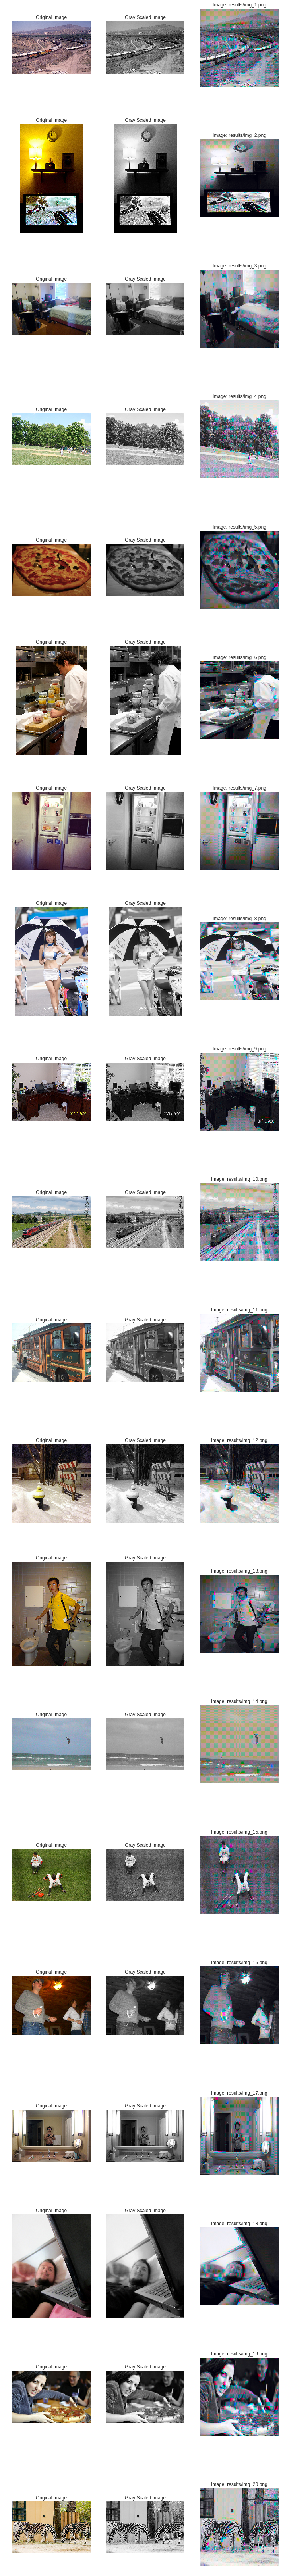

In [13]:
import re
from skimage.color import rgb2gray, gray2rgb

# Show images for test data
files = glob.glob("results/*.png")
org_files = glob.glob("dataset/test2014/*.jpg")

n_files = 20

def digit_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

files = digit_sort(files)[:n_files]
org_files = org_files[:n_files]

plt.figure(figsize=(12, 120))

for i, file_name in enumerate(files):
    # Original Image
    plt.subplot(n_files, 3, 3*i + 1)
    plt.axis('off')
    org_file_name = org_files[i]
    org_img = mpimg.imread(org_file_name)
    plt.title('Original Image')
    plt.imshow(org_img)
    # Gray Scaled Image
    plt.subplot(n_files, 3, 3*i + 2)
    plt.axis('off')
    org_img = mpimg.imread(org_file_name)
    plt.title('Gray Scaled Image')
    plt.imshow(gray2rgb(rgb2gray(org_img)))
    # Predicted Colored Image
    plt.subplot(n_files, 3, 3*i + 3)
    plt.axis('off')
    img = mpimg.imread(file_name)
    plt.title('Image: %s' % file_name)
    plt.imshow(img)


## Conclusions and Future Work
...